<a href="https://colab.research.google.com/github/rjgoyln/Deep-Learning-Mid-term/blob/main/rolling_avg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/Deep Learning Mid-term Programming Exam 202404"

/content/drive/MyDrive/Colab Notebooks/Deep Learning Mid-term Programming Exam 202404


In [ ]:
# 匯入基本套件
import os
import random
import pandas as pd
import numpy as np
import tensorflow as tf

# 1. 設定固定的 random seed 數字
SEED = 42  # 你可以換成任何自己喜歡的數字

# 2. Python 基礎層面設定
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# 3. Numpy 設定
np.random.seed(SEED)

# 4. TensorFlow 設定
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # (可選) 讓 TensorFlow 也盡量走固定路徑

# (選擇性) 讓 TensorFlow 日誌輸出更乾淨
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # '2' 表示只輸出 warning 和 error


In [ ]:
# 讀取資料
air_visit = pd.read_csv('air_visit_data.csv')
air_reserve = pd.read_csv('air_reserve.csv')
hpg_reserve = pd.read_csv('hpg_reserve.csv')
store_relation = pd.read_csv('store_id_relation.csv')
air_info = pd.read_csv('air_store_info.csv')
hpg_info = pd.read_csv('hpg_store_info.csv')
date_info = pd.read_csv('date_info.csv')

In [ ]:
# 處理 air_visit 的時間特徵
air_visit['visit_date'] = pd.to_datetime(air_visit['visit_date'])
air_visit.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [ ]:
# 處理 air_reserve 精確到小時
air_reserve['visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime'])
air_reserve['reserve_datetime'] = pd.to_datetime(air_reserve['reserve_datetime'])

# 計算預約提前時間（小時）
air_reserve['reserve_diff_hours'] = (air_reserve['visit_datetime'] - air_reserve['reserve_datetime']).dt.total_seconds() / 3600

# 轉成日期格式（用於 groupby）
air_reserve['visit_date'] = air_reserve['visit_datetime'].dt.date
air_reserve['visit_date'] = pd.to_datetime(air_reserve['visit_date'])

# 聚合：每家餐廳、每天的總預約人數、平均預約人數、平均預約提前小時
air_res_agg = air_reserve.groupby(['air_store_id', 'visit_date']).agg({
    'reserve_visitors': ['sum', 'mean'],
    'reserve_diff_hours': ['mean']
}).reset_index()

# 展平成單層欄位名稱
air_res_agg.columns = ['air_store_id', 'visit_date', 'res_visitors_sum', 'res_visitors_mean', 'res_diff_hours_mean']

# 檢查前幾筆
air_res_agg.head()


,air_store_id,visit_date,res_visitors_sum,res_visitors_mean,res_diff_hours_mean
0,air_00a91d42b08b08d9,2016-10-31,2,2.0,4.0
1,air_00a91d42b08b08d9,2016-12-05,9,9.0,100.0
2,air_00a91d42b08b08d9,2016-12-14,18,18.0,153.0
3,air_00a91d42b08b08d9,2016-12-17,2,2.0,147.0
4,air_00a91d42b08b08d9,2016-12-20,4,4.0,51.0


In [ ]:
# 處理 hpg_reserve 並轉換為 air_store_id
hpg_reserve = hpg_reserve.merge(store_relation, how='inner', on='hpg_store_id')

# 轉換為 datetime 格式
hpg_reserve['visit_datetime'] = pd.to_datetime(hpg_reserve['visit_datetime'])
hpg_reserve['reserve_datetime'] = pd.to_datetime(hpg_reserve['reserve_datetime'])

# 計算預約提前時間（以小時為單位）
hpg_reserve['reserve_diff_hours'] = (hpg_reserve['visit_datetime'] - hpg_reserve['reserve_datetime']).dt.total_seconds() / 3600

# 新增 visit_date 欄位以便 groupby
hpg_reserve['visit_date'] = hpg_reserve['visit_datetime'].dt.date
hpg_reserve['visit_date'] = pd.to_datetime(hpg_reserve['visit_date'])

# 每家餐廳、每天的總預約人數、平均預約人數、平均提前時間（小時）
hpg_res_agg = hpg_reserve.groupby(['air_store_id', 'visit_date']).agg({
    'reserve_visitors': ['sum', 'mean'],
    'reserve_diff_hours': ['mean']
}).reset_index()

# 展平成單層欄位名稱
hpg_res_agg.columns = ['air_store_id', 'visit_date', 'hpg_res_visitors_sum', 'hpg_res_visitors_mean', 'hpg_res_diff_hours_mean']

# 顯示結果
hpg_res_agg.head()


,air_store_id,visit_date,hpg_res_visitors_sum,hpg_res_visitors_mean,hpg_res_diff_hours_mean
0,air_00a91d42b08b08d9,2016-01-14,2,2.0,77.0
1,air_00a91d42b08b08d9,2016-01-15,4,4.0,142.0
2,air_00a91d42b08b08d9,2016-01-16,2,2.0,70.0
3,air_00a91d42b08b08d9,2016-01-22,2,2.0,82.0
4,air_00a91d42b08b08d9,2016-01-29,5,5.0,144.0


In [ ]:
# 處理日期資訊（假日）
date_info['calendar_date'] = pd.to_datetime(date_info['calendar_date'])
date_info = date_info.rename(columns={'calendar_date': 'visit_date'})
date_info['day_of_week'] = pd.to_datetime(date_info['visit_date']).dt.dayofweek
date_info.head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,4,1
1,2016-01-02,5,1
2,2016-01-03,6,1
3,2016-01-04,0,0
4,2016-01-05,1,0


In [ ]:
# 合併所有資訊到 air_visit
df = air_visit.copy()
df = df.merge(air_info, how='left', on='air_store_id')
df = df.merge(air_res_agg, how='left', on=['air_store_id', 'visit_date'])
df = df.merge(hpg_res_agg, how='left', on=['air_store_id', 'visit_date'])
df = df.merge(date_info, how='left', on='visit_date')
df.to_csv('/content/my_dataframe.csv', index=False)  # 儲存為 CSV 檔案，不儲存索引
df.head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,res_visitors_sum,res_visitors_mean,res_diff_hours_mean,hpg_res_visitors_sum,hpg_res_visitors_mean,hpg_res_diff_hours_mean,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,2,0
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,3,0
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,4,0
3,air_ba937bf13d40fb24,2016-01-16,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,5,0
4,air_ba937bf13d40fb24,2016-01-18,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [ ]:
# 先確保日期排序正確
df = df.sort_values(['air_store_id', 'visit_date'])

# 建立前一天的來客數 (lag1)
df['visitors_lag1'] = df.groupby('air_store_id')['visitors'].shift(1)

# 建立過去7天的平均來客數 (rolling mean)
df['visitors_rolling7'] = df.groupby('air_store_id')['visitors'].shift(1).rolling(window=7).mean()

df['visitors_rolling30'] = df.groupby('air_store_id')['visitors'].shift(1).rolling(window=30).mean()

df.head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,res_visitors_sum,res_visitors_mean,res_diff_hours_mean,hpg_res_visitors_sum,hpg_res_visitors_mean,hpg_res_diff_hours_mean,day_of_week,holiday_flg,visitors_lag1,visitors_rolling7,visitors_rolling30
87534,air_00a91d42b08b08d9,2016-07-01,35,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,NaN,NaN,NaN,1.0,1.0,29.0,4,0,NaN,NaN,NaN
87535,air_00a91d42b08b08d9,2016-07-02,9,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,NaN,NaN,NaN,NaN,NaN,NaN,5,0,35.0,NaN,NaN
87536,air_00a91d42b08b08d9,2016-07-04,20,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,NaN,NaN,NaN,NaN,NaN,NaN,0,0,9.0,NaN,NaN
87537,air_00a91d42b08b08d9,2016-07-05,25,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,NaN,NaN,NaN,NaN,NaN,NaN,1,0,20.0,NaN,NaN
87538,air_00a91d42b08b08d9,2016-07-06,29,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,NaN,NaN,NaN,7.0,7.0,278.0,2,0,25.0,NaN,NaN


In [ ]:
# 類別特徵 Label Encoding（轉換文字成數字）
from sklearn.preprocessing import LabelEncoder

for col in ['air_genre_name', 'air_area_name']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# 填補 NaN 值（可改進）
df.fillna(-1, inplace=True)

# 顯示前幾筆看看
df.head()
# df.describe()


,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,res_visitors_sum,res_visitors_mean,res_diff_hours_mean,hpg_res_visitors_sum,hpg_res_visitors_mean,hpg_res_diff_hours_mean,day_of_week,holiday_flg,visitors_lag1,visitors_rolling7,visitors_rolling30
87534,air_00a91d42b08b08d9,2016-07-01,35,6,44,35.694003,139.753595,-1.0,-1.0,-1.0,1.0,1.0,29.0,4,0,-1.0,-1.0,-1.0
87535,air_00a91d42b08b08d9,2016-07-02,9,6,44,35.694003,139.753595,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,5,0,35.0,-1.0,-1.0
87536,air_00a91d42b08b08d9,2016-07-04,20,6,44,35.694003,139.753595,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,9.0,-1.0,-1.0
87537,air_00a91d42b08b08d9,2016-07-05,25,6,44,35.694003,139.753595,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,0,20.0,-1.0,-1.0
87538,air_00a91d42b08b08d9,2016-07-06,29,6,44,35.694003,139.753595,-1.0,-1.0,-1.0,7.0,7.0,278.0,2,0,25.0,-1.0,-1.0


In [ ]:
train_df = df[df['visit_date'] < '2017-01-01']
test_df = df[df['visit_date'] >= '2017-01-01']

features = [col for col in df.columns if col not in ['visitors', 'visit_date', 'air_store_id']]
X_train = train_df[features]
y_train = train_df['visitors']

X_test = test_df[features]
y_test = test_df['visitors']

In [ ]:
# from sklearn.preprocessing import StandardScaler

# # 建立 scaler
# scaler = StandardScaler()

# # 對訓練集進行 fit_transform，對測試集只 transform
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


In [ ]:
# import pandas as pd

# Q1 = y_train.quantile(0.25)
# Q3 = y_train.quantile(0.75)
# IQR = Q3 - Q1

# # 設定上下限
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # 篩選非極端值資料
# mask = (y_train >= lower_bound) & (y_train <= upper_bound)
# X_train_filtered = X_train_scaled[mask]
# y_train_filtered = y_train[mask]


In [ ]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(1))  # 回歸輸出

# 編譯模型
import tensorflow as tf
from tensorflow.keras import backend as K

def rmsle_loss(y_true, y_pred):
    # 將 y_true 和 y_pred 轉換為 float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # 把負值裁成0，避免log爆掉
    y_true = K.maximum(y_true, 0)
    y_pred = K.maximum(y_pred, 0)

    # 使用 TensorFlow 的 log1p
    first_log = tf.math.log1p(y_pred)
    second_log = tf.math.log1p(y_true)

    return K.sqrt(K.mean(K.square(first_log - second_log)))


model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[rmsle_loss]   # 可以順便把 rmsle 當成指標顯示
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,137 (12.25 KB)

 Trainable params: 3,137 (12.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# 加上 EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

epoch = 100
batch_size = 512
# 訓練模型並儲存訓練過程的歷史紀錄
history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_split=0.2, callbacks=[early_stop])


Epoch 1/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 253.2581 - rmsle_loss: 0.8869 - val_loss: 177.5929 - val_rmsle_loss: 0.6374
Epoch 2/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 155.2275 - rmsle_loss: 0.6347 - val_loss: 173.0906 - val_rmsle_loss: 0.6261
Epoch 3/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 150.8723 - rmsle_loss: 0.6259 - val_loss: 170.8606 - val_rmsle_loss: 0.6200
Epoch 4/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 148.2490 - rmsle_loss: 0.6205 - val_loss: 168.9447 - val_rmsle_loss: 0.6140
Epoch 5/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 146.2701 - rmsle_loss: 0.6151 - val_loss: 167.2621 - val_rmsle_loss: 0.6089
Epoch 6/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 144.8262 - rmsle_loss: 0.6110 - val_loss: 166.3082 - val_rmsle_loss: 0.6027
Epoch 7/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 144.1370 - rmsle_loss: 0.6084 - val_loss: 165.7710 - val_rmsle_loss: 0.5983
Epoch 8/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
y_pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

2425/2425 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


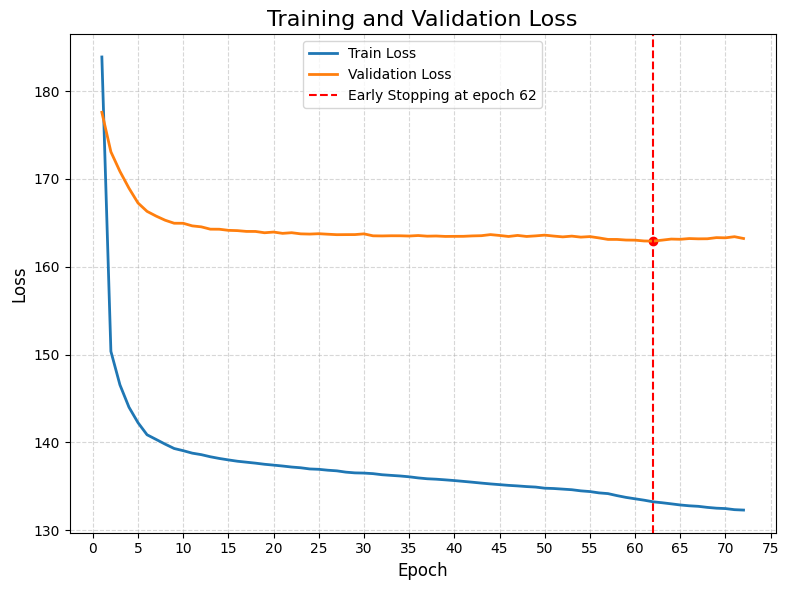

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 取出歷史紀錄
loss = history.history['loss']
val_loss = history.history['val_loss']

# x軸從1開始
epochs = range(1, len(loss) + 1)

# 找到最佳 Early Stopping 的 epoch
best_epoch = early_stop.stopped_epoch - early_stop.patience
best_val_loss = min(val_loss)

# 畫圖
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, label='Train Loss', linewidth=2)
plt.plot(epochs, val_loss, label='Validation Loss', linewidth=2)

# 標記 EarlyStopping 發生的位置
plt.axvline(x=best_epoch + 1, color='red', linestyle='--', label=f'Early Stopping at epoch {best_epoch + 1}')
plt.scatter(best_epoch + 1, best_val_loss, color='red')

# x軸每5個顯示一個
plt.xticks(np.arange(0, len(loss)+5, 5))  # 0到最大epoch，每5步一個tick

plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
stopped_epoch = early_stop.stopped_epoch
if stopped_epoch > 0:
    print(f"Early stopping triggered at epoch {stopped_epoch + 1}/{epoch}")
else:
    print("Early stopping was not triggered.")

print(f"batch size: {batch_size}")

print("- - - - - - - - - - - - - - - - - - - - - - -")
# train result
print("loss function: " + model.loss)
print(f"train loss(correspond to best val): {loss[best_epoch]:.4f}")
print(f"best val loss: {best_val_loss:.4f}")

print("- - - - - - - - - - - - - - - - - - - - - - -")
# test result
print(f"Test MSE: {mse:.4f}")

# mean_visitors = y_test.mean()
# print(f"Relative RMSE: {(rmse / mean_visitors) * 100:.2f}%")

# RMSLE
import numpy as np

def rmsle(y_true, y_pred):
    # 把負數裁成0，避免 log 出現錯誤
    y_true = np.maximum(0, y_true)
    y_pred = np.maximum(0, y_pred)

    # 計算 RMSLE
    return np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred)) ** 2))

# 用你的 y_test, y_pred 計算
rmsle_score = rmsle(y_test, y_pred.flatten())

print(f"Test RMSLE: {rmsle_score:.4f}")


Early stopping triggered at epoch 72/100
batch size: 512
- - - - - - - - - - - - - - - - - - - - - - -
loss function: mean_squared_error
train loss(correspond to best val): 133.2201
best val loss: 162.9186
- - - - - - - - - - - - - - - - - - - - - - -
Test MSE: 263.0153
Test RMSLE: 0.5928


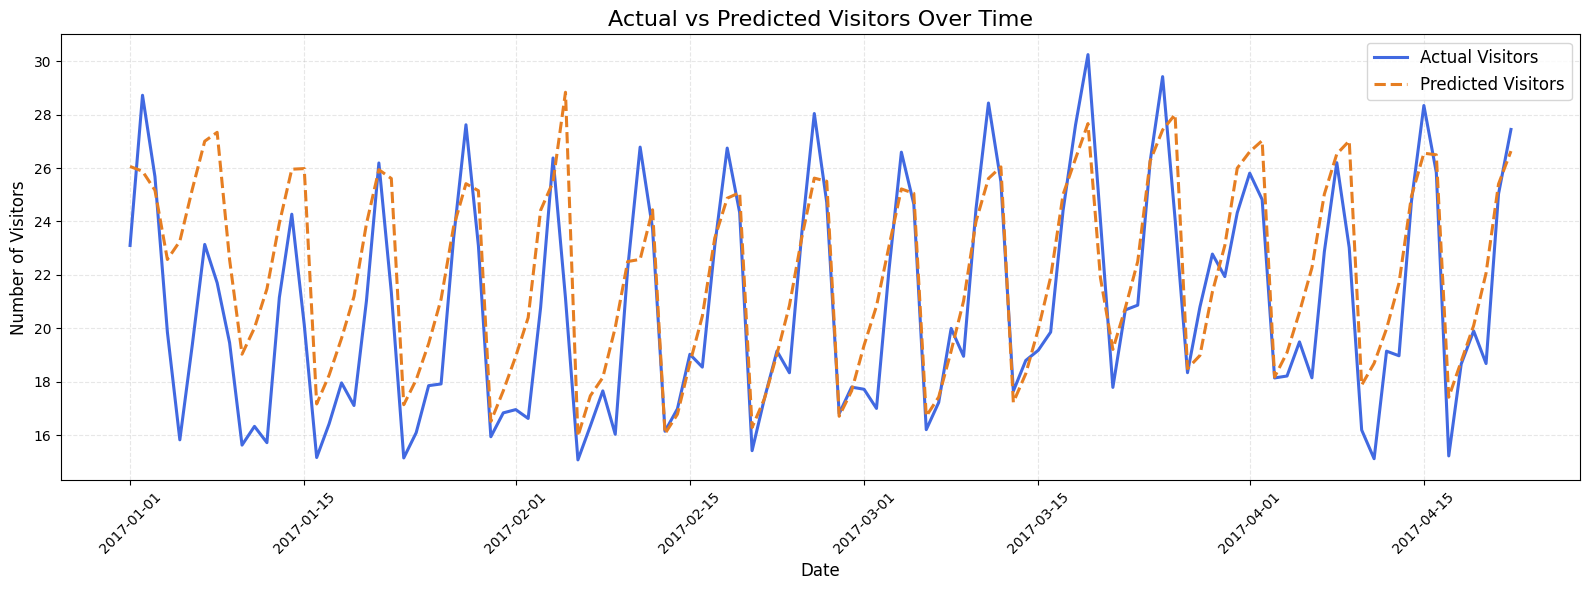

In [ ]:
test_dates = df.loc[X_test.index, 'visit_date']
result_df = pd.DataFrame({'date': test_dates, 'actual': y_test, 'predicted': y_pred.flatten()})
result_df = result_df.sort_values('date')

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

# 畫實際值（實線）
sns.lineplot(data=result_df, x='date', y='actual', label='Actual Visitors',
             linewidth=2.2, color='royalblue', errorbar=None)

# 畫預測值（虛線）
sns.lineplot(data=result_df, x='date', y='predicted', label='Predicted Visitors',
             linewidth=2.2, color='#e67e22', linestyle='--', errorbar=None)

# 美化
plt.title("Actual vs Predicted Visitors Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Visitors", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

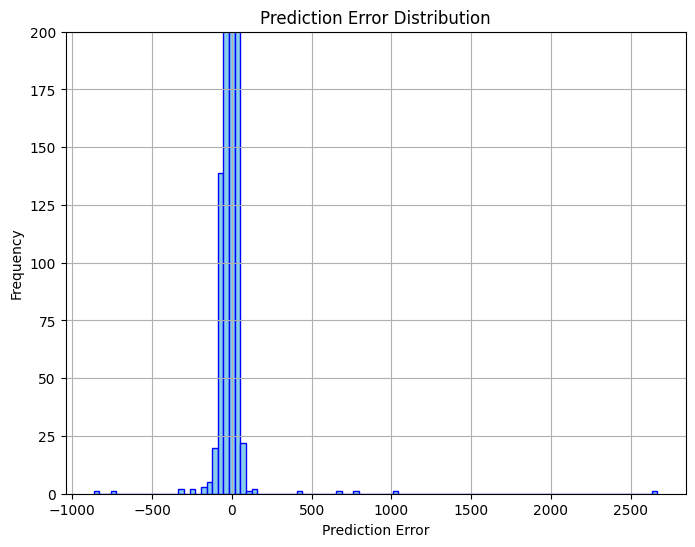

(77573,)


In [ ]:
# 看一下誤差分布
result_df['error'] = result_df['predicted'] - result_df['actual']
plt.figure(figsize=(8, 6))
plt.hist(result_df['error'], bins=100, color='skyblue', edgecolor='blue')
plt.title("Prediction Error Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.ylim(0, 200)  # 限制橫軸範圍
#　plt.xlim(-100, 100)
plt.grid(True)
plt.show()
print(y_test.shape)